In [1]:
import ta
import numpy as np
import pandas as pd
import random

import warnings
# Turn off all warnings
warnings.filterwarnings("ignore")

In [754]:
import ccxt
import pandas as pd
import re
import random

# Fetch OHLCV data from Kraken
def fetch_ohlcv_data(start_date, limit=None):
    exchange = ccxt.kraken()
    symbol = 'BTC/AUD'
    timeframe = '1d'
    since = exchange.parse8601(start_date)
    ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since, limit=limit)
    
    # Convert the data to a Pandas DataFrame and set column names
    ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'o', 'h', 'l', 'c', 'v'])
    # Convert the timestamp to a human-readable datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

    return ohlcv_df

origin_ohlcv_data = fetch_ohlcv_data("2021-01-01T00:00:00Z")

print(origin_ohlcv_data[:3])

   timestamp        o        h        l        c          v
0 2021-05-16  60772.4  64094.7  56733.2  60065.5  26.615730
1 2021-05-17  59974.1  60193.9  54452.0  55863.5  39.069198
2 2021-05-18  56175.5  58914.0  54331.0  55151.4  35.232002


In [ ]:
ohlcv_data = origin_ohlcv_data.copy()

In [417]:
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
from ta.volatility import BollingerBands
from ta.momentum import StochasticOscillator
from ta.volatility import AverageTrueRange

def bollinger_bands_upper(data, bollinger_period=20, bollinger_std_dev=2):
    bollinger_string = f"bollinger_upper_{bollinger_period}_{bollinger_std_dev:.2f}".replace('.', '_')
    if bollinger_string in data.columns:
        return bollinger_string
    bollinger_indicator = BollingerBands(data['c'], window=bollinger_period, window_dev=bollinger_std_dev)
    data[bollinger_string] = bollinger_indicator.bollinger_hband()
    return bollinger_string

def bollinger_bands_lower(data, bollinger_period=20, bollinger_std_dev=2):
    bollinger_string = f"bollinger_lower_{bollinger_period}_{bollinger_std_dev:.2f}".replace('.', '_')
    if bollinger_string in data.columns:
        return bollinger_string
    bollinger_indicator = BollingerBands(data['c'], window=bollinger_period, window_dev=bollinger_std_dev)
    data[bollinger_string] = bollinger_indicator.bollinger_lband()
    return bollinger_string

def stochastic_oscillator_K(data, k_period=14, d_period=3):
    stoch_k_string = f"stochastic_K_{k_period}_{d_period}"
    if stoch_k_string in data.columns:
        return stoch_k_string
    stoch_indicator = StochasticOscillator(data['h'], data['l'], data['c'], k_period, d_period)
    data[stoch_k_string] = stoch_indicator.stoch()
    return stoch_k_string

def stochastic_oscillator_D(data, k_period=14, d_period=3):
    stoch_d_string = f"stochastic_D_{k_period}_{d_period}"
    if stoch_d_string in data.columns:
        return stoch_d_string
    stoch_indicator = StochasticOscillator(data['h'], data['l'], data['c'], k_period, d_period)
    data[stoch_d_string] = stoch_indicator.stoch_signal()
    return stoch_d_string

def atr(data, atr_period=14):
    atr_string = f"atr_{atr_period}"
    if atr_string in data.columns:
        return atr_string
    atr_indicator = AverageTrueRange(data['h'], data['l'], data['c'], window=atr_period)
    data[atr_string] = atr_indicator.average_true_range()
    return atr_string

def rsi(data, rsi_period = 14):
    rsi_string = f"rsi_{rsi_period}"
    if rsi_string in data.columns:
        return rsi_string
    rsi_indicator = RSIIndicator(data['c'], window=rsi_period)
    rsi = rsi_indicator.rsi()
    data[rsi_string] = rsi
    return rsi_string

def sma(data, sma_period=20):
    sma_string = f"sma_{sma_period}"
    if sma_string in data.columns:
        return sma_string
    sma_indicator = SMAIndicator(data['c'], window=sma_period)
    sma = sma_indicator.sma_indicator()
    data[sma_string] = sma
    return sma_string

def macd(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_string = f"macd_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_string in data.columns:
        return macd_string
    macd_indicator = MACD(ohlcv_data['c'], macd_fast, macd_slow, macd_signal)
    macd = macd_indicator.macd()  # MACD line
    data[macd_string] = macd
    return macd_string

def macd_signal(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_sig_string = f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_sig_string in data.columns:
        return macd_sig_string
    macd_indicator = MACD(ohlcv_data['c'], macd_fast, macd_slow, macd_signal)
    macd_sig = macd_indicator.macd_signal()  # Signal line
    data[macd_sig_string] = macd_sig
    return macd_sig_string

def constant(data, constant=30):
    const_string = f"constant_{constant}"
    if const_string in data.columns:
        return const_string
    data[const_string] = constant
    return const_string

def candle(data,candle ="o"):
    return candle

In [733]:
class Value():
    def __init__(self):
        random_macd_choice = random.choice([[12, 26, 9], [24, 52, 18]])
        stochastic_oscillator_values = [random.randint(10, 20), random.randint(3, 5)]
        bollinger_bands_values = [random.randint(20, 40), round(random.uniform(1.5, 2.5), 2)]
        values = [
            ([constant, [30]],
            [rsi, [random.randint(14, 28)]]),
            ([rsi, [random.randint(14, 28)]],
            [constant, [70]]),
            ([sma, [random.randint(20, 40)]],
            [candle, 'o']),
            ([macd, random_macd_choice],
            [macd_signal, random_macd_choice]),
            ([bollinger_bands_lower, bollinger_bands_values],
             [bollinger_bands_upper, bollinger_bands_values]),
            ([constant, [20]],
            [stochastic_oscillator_K, stochastic_oscillator_values]),
            ([stochastic_oscillator_D, stochastic_oscillator_values],
            [constant, [80]]),
            ([atr, [random.randint(10, 20)]],
            [candle, 'h']),
        ]
        self.indicator = random.choice(values)
        self.column_name_1 = self.indicator[0][0](ohlcv_data, *self.indicator[0][1])
        self.column_name_2 = self.indicator[1][0](ohlcv_data, *self.indicator[1][1])

    def evaluate(self,time):
        return f'ohlcv_data.{self.column_name_1}.iloc[{time}]', f'ohlcv_data.{self.column_name_2}.iloc[{time}]'

    def __str__(self):
        return f'{self.column_name_1}, {self.column_name_2}'

class Literal():
    def __init__(self):
        self.negated = random.choice([True, False])
        self.value = Value()
        self.c = random.uniform(0.5, 1.5)

    def evaluate(self,time):
        val1, val2 = self.value.evaluate(time)
        if self.negated:
            return f'not({val1} > {self.c:.2f} * {val2})'
        return f'({val1} > {self.c:.2f} * {val2})'

    def __str__(self):
        if self.negated:
            return f'¬({self.value.column_name_1} > {self.c:.2f} * {self.value.column_name_2})'
        return f'({self.value.column_name_1} > {self.c:.2f} * {self.value.column_name_2})'

class Conjugate():
    def __init__(self):
        self.literals = []
        self.generate_lit()

    def generate_lit(self):
        rand_num = random.random()
        if rand_num < 0.5:
            self.literals.append(Literal())
            self.generate_lit()
            return
        self.literals.append(Literal())
        return 
    
    def evaluate(self,time):
        out_str =""
        for literal in self.literals:
            out_str += f"{literal.evaluate(time)} and "
        return out_str[:-5]

    def __str__(self):
        out_str =""
        for literal in self.literals:
            out_str += f"{literal.__str__()} ∧ "
        return out_str[:-3]
        
class Gene:
    def __init__(self) -> None:
        self.sell_conjugates = []
        self.buy_conjugates = []
        self.generate_buy_conjugates()
        self.generate_sell_conjugates()
    
    def generate_buy_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.2:
            self.buy_conjugates.append(Conjugate())
            self.generate_buy_conjugates()
            return
        self.buy_conjugates.append(Conjugate())
        return

    def generate_sell_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.2:
            self.sell_conjugates.append(Conjugate())
            self.generate_sell_conjugates()
            return
        self.sell_conjugates.append(Conjugate())
        return

    def evaluate_buy(self,time):
        out_str =""
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-4])

    def evaluate_sell(self,time):
        out_str =""
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-4])
    
    def count_literals(self):
        literal_count = 0
        for buy_conjugate in self.buy_conjugates:
            literal_count += len(buy_conjugate.literals)
        for sell_conjugate in self.sell_conjugates:
            literal_count += len(sell_conjugate.literals)
        return literal_count
    
    def update_weights(self, weights):
        if len(weights) != self.count_literals():
            raise ValueError("The number of weights provided does not match the number of literals in the gene.")
        weight_index = 0
        for buy_conjugate in self.buy_conjugates:
            for literal in buy_conjugate.literals:
                literal.c = weights[weight_index]
                weight_index += 1
        for sell_conjugate in self.sell_conjugates:
            for literal in sell_conjugate.literals:
                literal.c = weights[weight_index]
                weight_index += 1

    def __str__(self):
        out_str ="BUY CONDITIONS: "
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.__str__()}) ∨ "
        out_str = out_str[:-3]
        out_str += "\nSELL CONDITIONS: "
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.__str__()}) ∨ "
        out_str = out_str[:-3]
        return out_str
    
#ohlcv_data = origin_ohlcv_data.copy()
a = Gene()
print(a)
print(a.evaluate_buy(0))
print(a.evaluate_sell(0))

BUY CONDITIONS: (¬(rsi_17 > 0.50 * constant_70) ∧ ¬(sma_21 > 1.13 * o))
SELL CONDITIONS: (¬(macd_24_52_18 > 0.59 * macd_signal_24_52_18) ∧ (constant_20 > 1.07 * stochastic_K_13_3))
True
False


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


In [764]:
def trading_bot(gene, ohlcv_data, from_day=0, to_day=719):
    n = len(ohlcv_data[from_day:to_day])
    positions = []
    fiat_money = 100
    btc_money = 0
    fee = 0.02 # Each buy or sell event costs 2% of current holdings.

    for t in range(from_day, n):
        close_price = ohlcv_data.loc[t, 'c']      

        if (gene.evaluate_buy(t)) and (not gene.evaluate_buy(t-1)) and (not gene.evaluate_sell(t) and not gene.evaluate_sell(t-1)):
            positions.append(('buy', t))
            if(fiat_money > 0):
                btc_money = (fiat_money / close_price) * (1 - fee)
                fiat_money = 0
                #print(btc_money * close_price)
            
        elif (gene.evaluate_sell(t)) and (not gene.evaluate_sell(t-1)) and (not gene.evaluate_buy(t) and not gene.evaluate_buy(t-1)):
            positions.append(('sell', t))
            if(btc_money > 0):
                fiat_money = (btc_money * close_price) * (1 - fee)
                btc_money = 0
                #print(fiat_money)
    
    if len(positions) > 0:
        if positions[-1][0] == "buy":
            positions.append(('sell', n - 1))
            if(btc_money > 0):
                fiat_money = (btc_money * close_price) * (1 - fee)
                btc_money = 0
    else:
        #print("Fail")
        pass
        #fiat_money = 0 ## We didn't trade, so pretend result is 0

    return positions, fiat_money, btc_money
    
#ohlcv_data = origin_ohlcv_data.copy()
a = Gene()
print(a)
pos, fiat, btc = trading_bot(a, ohlcv_data)
print(pos)
if fiat == 0:
    print("Bust")
elif fiat == 100:
    print("No trades")
else:
    print(fiat)    

BUY CONDITIONS: ((rsi_15 > 0.73 * constant_70))
SELL CONDITIONS: (¬(constant_20 > 0.63 * stochastic_K_17_3))
[('sell', 17), ('sell', 24), ('sell', 38), ('sell', 42), ('sell', 66), ('sell', 129), ('sell', 137), ('sell', 188), ('sell', 196), ('sell', 199), ('sell', 202), ('sell', 209), ('sell', 219), ('sell', 230), ('sell', 243), ('sell', 247), ('sell', 253), ('sell', 284), ('sell', 296), ('sell', 302), ('sell', 338), ('sell', 344), ('sell', 346), ('sell', 350), ('sell', 353), ('sell', 363), ('sell', 366), ('sell', 368), ('sell', 371), ('sell', 373), ('sell', 379), ('sell', 384), ('sell', 405), ('sell', 410), ('sell', 423), ('sell', 462), ('sell', 495), ('sell', 498), ('sell', 559), ('buy', 576), ('sell', 588), ('sell', 597), ('buy', 636), ('sell', 665)]
93.82761746782407


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


In [765]:
import copy
import numpy as np

class Genome:
    def __init__(self, fitness, genes):
        self.fitness = fitness
        self.genes = genes

class Optimization():
    def __init__(self, population_size, generations, ohlcv_data, gene, to_day):
        self.population_size = population_size
        self.generations = generations
        self.ohlcv_data = ohlcv_data
        self.gene = gene
        self.num_literals = gene.count_literals()
        self.to_day = to_day # How many days the data is trained on

    def train(self):
        no_improvement = 0
        mutation_rate = 0.05
        population = self.initialize_population(self.population_size, self.num_literals)
        best_genome = population[0]
        # Evaluate the population
        for i in range(self.generations):
            population = self.evaluate_population(population)
            # Sort the population by fitness
            population.sort(key=lambda x: x.fitness, reverse=True)
            # # Keep track of the best genome
            print(f"Generation {i} best genome fitness: {population[0].fitness}, average fitness: {np.mean([x.fitness for x in population])}")
            # Bad DNF
            if(population[0].fitness <= 100):
                print("Top Fitness <= 100: Quitting")
                return population[0]
            if i > 0 and population[0].fitness == best_genome.fitness:
                no_improvement += 1
            else:
                no_improvement = 0
            # Update the mutation rate
            if no_improvement > 4:
                mutation_rate *= 1.1
            else:
                mutation_rate = 0.05
            best_genome = population[0]
            # 
            if no_improvement == 10:
                print("No improvement for 10 generations: Quitting")
                return best_genome
            # Do tournament selection for next generation
            population = self.tournament_selection(population, 0.05, 2, mutation_rate)
            population.sort(key=lambda x: x.fitness, reverse=True)
        return best_genome

    def initialize_population(self, population_size, num_literals):
        population = []
        for i in range(population_size):
            genes = np.random.uniform(0, 1, num_literals)
            population.append(Genome(0, genes))
        return population
    
    def evaluate_population(self, population):
        for genome in population:
            genome.fitness = self.fitness(genome)
        return population
    
    def fitness(self, weights):
        self.gene.update_weights(weights.genes)
        positions, fiat_money, btc_money = trading_bot(self.gene, ohlcv_data, to_day=self.to_day)
        return fiat_money + (btc_money * ohlcv_data.iloc[-1]['c'])	
    
    def tournament_selection(self, population, elitism, tournament_size, mutation_rate):
        # Select elite
        elite = population[:int(elitism * len(population))]
        # Initialize an empty list for the parents
        parents = []
        for _ in range(len(population) - len(elite)):
            # Randomly select tournament_size genomes
            tournament = np.random.choice(population, size=tournament_size)
            # Select the best genome
            winner = copy.deepcopy(max(tournament, key=lambda x: x.fitness))
            # Apply mutation to winner.genes
            for i in range(winner.genes.size):
                mutation = np.random.uniform(-mutation_rate, mutation_rate)
                winner.genes[i] = max(0, winner.genes[i] + mutation)
            # Add the winner to the parents list
            parents.append(winner)
        # Add the elite to the parents list
        parents.extend(elite)
        return parents

In [767]:
## Hard Reset (removes data collected from the code block below)
ohlcv_data = origin_ohlcv_data.copy()

In [780]:


geneList = []
goodGeneList = []
best_fitness = 0
best_gene = None
for x in range(0, 15):
    newGene = Gene()
    geneList.append(newGene)
    print(newGene)
    optimization = Optimization(population_size=70, generations=7, ohlcv_data=ohlcv_data, gene=newGene, to_day=200)
    best_genome = optimization.train()
    newGene.update_weights(best_genome.genes)
    positions, fiat_money, btc_money = trading_bot(newGene, ohlcv_data, from_day=0, to_day=719)
    if(fiat_money > 100): # Validation
        goodGeneList.append(newGene)
        print(f"Final DNF Expression: ")
        print(optimization.gene)
        print("Best genome:", best_genome.genes)
        print("Best genome fitness:", best_genome.fitness)
        if(best_genome.fitness > best_fitness):
            best_fitness = best_genome.fitness
            best_gene = newGene


BUY CONDITIONS: ((stochastic_D_14_4 > 0.86 * constant_80))
SELL CONDITIONS: ((constant_20 > 1.03 * stochastic_K_11_3))
Generation 0 best genome fitness: 176.40816321684233, average fitness: 118.06818630563681
Generation 1 best genome fitness: 176.40816321684233, average fitness: 130.10859607385163
Generation 2 best genome fitness: 176.40816321684233, average fitness: 139.23996794451864
Generation 3 best genome fitness: 176.40816321684233, average fitness: 145.81996169213792
Generation 4 best genome fitness: 176.40816321684233, average fitness: 150.30728557885652
Generation 5 best genome fitness: 176.40816321684233, average fitness: 153.86164162791755
Generation 6 best genome fitness: 176.40816321684233, average fitness: 153.18093263100474
Final DNF Expression: 
BUY CONDITIONS: ((stochastic_D_14_4 > 0.35 * constant_80))
SELL CONDITIONS: ((constant_20 > 0.36 * stochastic_K_11_3))
Best genome: [0.35194067 0.35508895]
Best genome fitness: 176.40816321684233
BUY CONDITIONS: (¬(macd_12_26_9 

C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[atr_string] = atr_indicator.average_true_range()


Generation 0 best genome fitness: 177.79906756666566, average fitness: 104.64422055702946
Generation 1 best genome fitness: 177.79906756666566, average fitness: 107.92643906946192
Generation 2 best genome fitness: 177.79906756666566, average fitness: 118.02117009996954
Generation 3 best genome fitness: 177.79906756666566, average fitness: 136.63063436990515
Generation 4 best genome fitness: 177.79906756666566, average fitness: 150.9334264047193
Generation 5 best genome fitness: 177.79906756666566, average fitness: 170.6353783291186
Generation 6 best genome fitness: 177.79906756666566, average fitness: 171.5912818297432
BUY CONDITIONS: ((sma_40 > 0.80 * o) ∧ (stochastic_D_11_3 > 0.91 * constant_80))
SELL CONDITIONS: ((rsi_24 > 1.28 * constant_70)) ∨ (¬(atr_19 > 0.75 * h))


C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_string] = sma
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[atr_string] = atr_indicator.average_true_range()


Generation 0 best genome fitness: 154.44182720490815, average fitness: 101.4102709694881
Generation 1 best genome fitness: 161.88136709656467, average fitness: 103.56097691073013
Generation 2 best genome fitness: 169.49563248839686, average fitness: 110.56014743997574
Generation 3 best genome fitness: 169.49563248839686, average fitness: 118.61402292993405
Generation 4 best genome fitness: 173.66226553345626, average fitness: 126.83036262910998
Generation 5 best genome fitness: 174.33125953552994, average fitness: 137.07250786738766
Generation 6 best genome fitness: 174.33125953552994, average fitness: 148.96668951589655
BUY CONDITIONS: (¬(rsi_16 > 0.74 * constant_70))
SELL CONDITIONS: ((rsi_24 > 1.27 * constant_70) ∧ (stochastic_D_18_4 > 0.92 * constant_80))
Generation 0 best genome fitness: 168.0199235769635, average fitness: 101.97591742054159
Generation 1 best genome fitness: 168.0199235769635, average fitness: 108.06589595857342
Generation 2 best genome fitness: 177.93952922317217

C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_lband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[bollinger_string] = bollinger_indicator.bollinger_hband()
C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

BUY CONDITIONS: ((macd_12_26_9 > 1.15 * macd_signal_12_26_9))
SELL CONDITIONS: (¬(atr_12 > 1.12 * h) ∧ (bollinger_lower_33_1_68 > 0.62 * bollinger_upper_33_1_68) ∧ (sma_37 > 1.25 * o) ∧ (bollinger_lower_31_2_04 > 1.47 * bollinger_upper_31_2_04) ∧ (sma_22 > 1.38 * o) ∧ ¬(bollinger_lower_23_1_67 > 0.51 * bollinger_upper_23_1_67)) ∨ ((stochastic_D_15_5 > 1.10 * constant_80))
Generation 0 best genome fitness: 138.53236851912473, average fitness: 101.2409294215201
Generation 1 best genome fitness: 141.7719537859325, average fitness: 103.96188662049607
Generation 2 best genome fitness: 141.7719537859325, average fitness: 107.4719445880949
Generation 3 best genome fitness: 142.26077299847952, average fitness: 109.50887382298909
Generation 4 best genome fitness: 142.26077299847952, average fitness: 113.35683233754543
Generation 5 best genome fitness: 142.26077299847952, average fitness: 112.43898313740492
Generation 6 best genome fitness: 142.26077299847952, average fitness: 112.82196920447863

C:\Users\StuartM\AppData\Local\Temp\ipykernel_1700\632209351.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stoch_k_string] = stoch_indicator.stoch()


BUY CONDITIONS: ((atr_12 > 1.21 * h))
SELL CONDITIONS: ((constant_20 > 0.91 * stochastic_K_19_3))
Generation 0 best genome fitness: 155.16833578366396, average fitness: 102.10805884695591
Generation 1 best genome fitness: 155.16833578366396, average fitness: 107.92975854743759
Generation 2 best genome fitness: 155.16833578366396, average fitness: 113.08995606620368
Generation 3 best genome fitness: 155.16833578366396, average fitness: 124.69803999605195
Generation 4 best genome fitness: 155.16833578366396, average fitness: 134.46146394570943
Generation 5 best genome fitness: 155.16833578366396, average fitness: 133.9724180553832
Generation 6 best genome fitness: 155.16833578366396, average fitness: 135.1108660982341


In [781]:
# Take the genes that passed validation and optimize them more
# This probably makes the genes overfit for the first 200 days
# Just a thought.

toBeOptimizedFurtherGenes = copy.deepcopy(goodGeneList)

for x in toBeOptimizedFurtherGenes:
    optimization = Optimization(population_size=200, generations=30, ohlcv_data=ohlcv_data, gene=x, to_day=200)
    best_genome = optimization.train()
    x.update_weights(best_genome.genes)
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"Final DNF Expression: ")
    print(optimization.gene)
    print("Best genome:", best_genome.genes)
    print("Best genome fitness:", best_genome.fitness)
       

Generation 0 best genome fitness: 176.40816321684233, average fitness: 111.34934153705825
Generation 1 best genome fitness: 176.40816321684233, average fitness: 124.83594087405935
Generation 2 best genome fitness: 176.40816321684233, average fitness: 139.26773922134925
Generation 3 best genome fitness: 176.40816321684233, average fitness: 151.39484121300774
Generation 4 best genome fitness: 176.40816321684233, average fitness: 155.59410228821054
Generation 5 best genome fitness: 176.40816321684233, average fitness: 159.96740739113997
Generation 6 best genome fitness: 176.40816321684233, average fitness: 156.25197697609602
Generation 7 best genome fitness: 176.40816321684233, average fitness: 155.39353385730092
Generation 8 best genome fitness: 176.40816321684233, average fitness: 155.04227779582536
Generation 9 best genome fitness: 176.40816321684233, average fitness: 150.78575363155676
Generation 10 best genome fitness: 176.40816321684233, average fitness: 150.92572357805975
No improv

In [783]:
## Does further optimization work? spoiler:no
for i, x in enumerate(goodGeneList):
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"{i}: {fiat_money}")
    print(x)
print()
print(f"Further Optimized:")
for i, x in enumerate(toBeOptimizedFurtherGenes):
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"{i}: {fiat_money}")
    print(x)


0: 160.1288525652034
BUY CONDITIONS: ((stochastic_D_14_4 > 0.35 * constant_80))
SELL CONDITIONS: ((constant_20 > 0.36 * stochastic_K_11_3))
1: 142.64982246398978
BUY CONDITIONS: (¬(rsi_21 > 0.65 * constant_70))
SELL CONDITIONS: ((rsi_24 > 0.09 * constant_70) ∧ (sma_36 > 0.65 * o) ∧ ¬(stochastic_D_20_5 > 0.69 * constant_80) ∧ (sma_32 > 0.72 * o)) ∨ ((rsi_20 > 0.56 * constant_70) ∧ ¬(sma_24 > 0.81 * o) ∧ ¬(constant_30 > 0.18 * rsi_17)) ∨ ((sma_36 > 0.56 * o) ∧ ¬(constant_20 > 0.19 * stochastic_K_12_3))
2: 102.18305916270299
BUY CONDITIONS: ((constant_30 > 0.80 * rsi_17)) ∨ (¬(macd_12_26_9 > 0.71 * macd_signal_12_26_9))
SELL CONDITIONS: (¬(rsi_25 > 0.16 * constant_70) ∧ (sma_20 > 0.68 * o) ∧ (macd_24_52_18 > 0.81 * macd_signal_24_52_18) ∧ ¬(atr_18 > 0.92 * h))
3: 195.8302352962854
BUY CONDITIONS: (¬(stochastic_D_10_3 > 0.36 * constant_80) ∧ ¬(sma_35 > 0.60 * o) ∧ (rsi_16 > 0.22 * constant_70) ∧ ¬(macd_24_52_18 > 0.60 * macd_signal_24_52_18))
SELL CONDITIONS: (¬(constant_30 > 0.42 * rsi_19

160.1288525652034


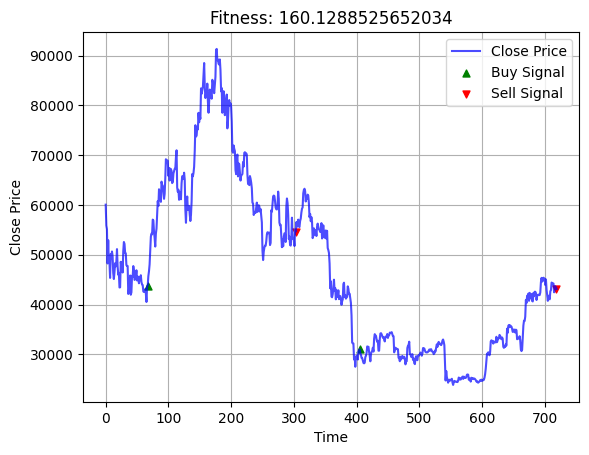

142.64982246398978


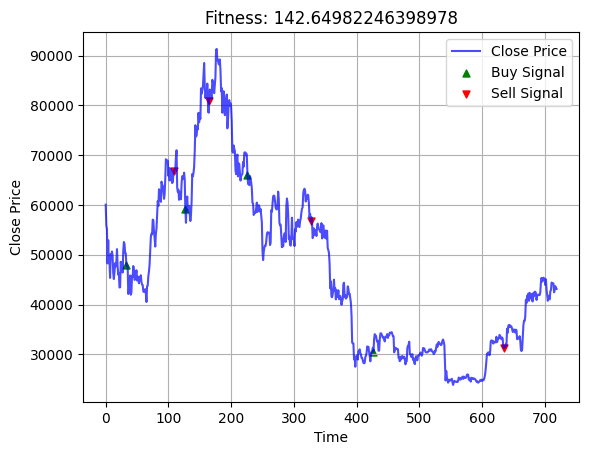

102.18305916270299


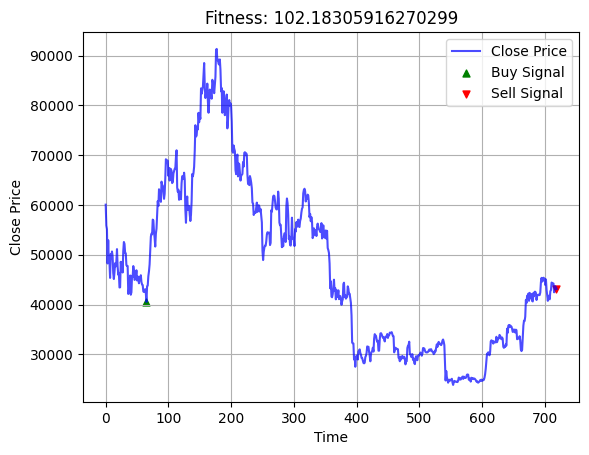

195.8302352962854


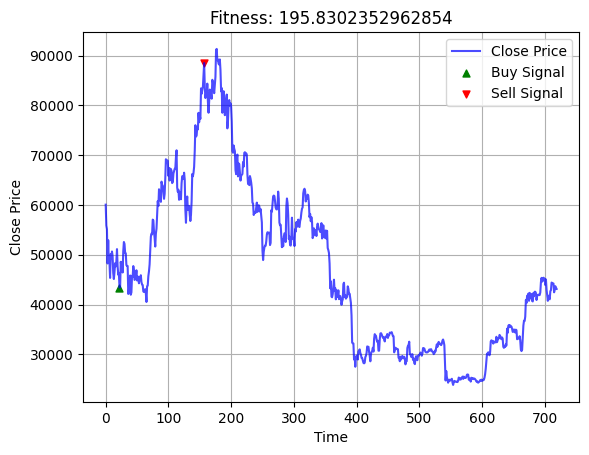

190.9506529452638


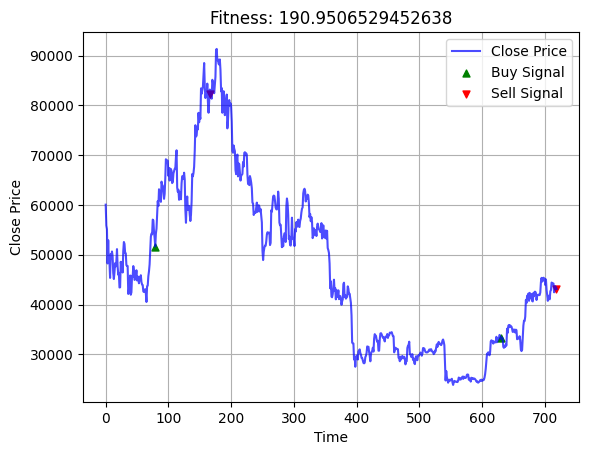

114.65859642934946


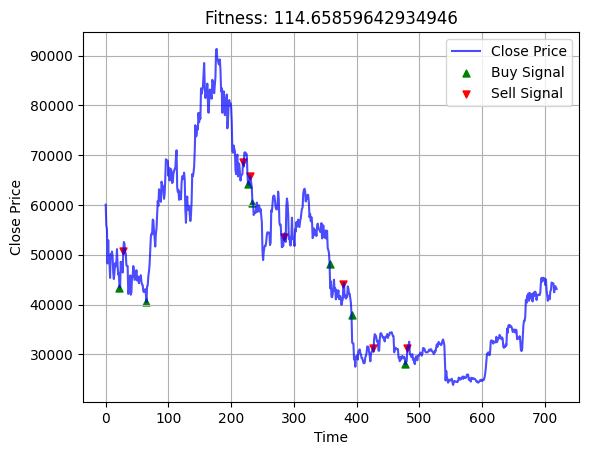

In [784]:
def numberOfEvents(positions):
    while len(positions) > 0 and positions[0][0] == 'sell':
        positions.pop(0)
    if len(positions) > 0:
        trimmed = [positions[0]]
        for i in range(1, len(positions)):
            if positions[i][0] != positions[i-1][0]:
                trimmed.append(positions[i])
    else:
        return positions
    return trimmed

for gene in goodGeneList:
    positions, fiat_money, btc_money = trading_bot(gene, ohlcv_data, from_day=0, to_day=719)
    #print(positions)
    positions = numberOfEvents(positions)



    print(fiat_money + (btc_money * ohlcv_data.iloc[-1]['c']))
    import matplotlib.pyplot as plt

    # Extract the timestamps, close prices, and buy/sell signals
    timestamps = ohlcv_data.index
    close_prices = ohlcv_data['c']
    buy_signals = [t for action, t in positions if action == 'buy']
    sell_signals = [t for action, t in positions if action == 'sell']

    # Plot the price data
    plt.plot(timestamps, close_prices, label='Close Price', color='blue', alpha=0.7)

    # Plot the buy signals
    plt.scatter([timestamps[t] for t in buy_signals],
                [close_prices[t] for t in buy_signals],
                color='g', s=25, marker="^", label='Buy Signal')

    # Plot the sell signals
    plt.scatter([timestamps[t] for t in sell_signals],
                [close_prices[t] for t in sell_signals],
                color='r', s=25, marker="v", label='Sell Signal')

    # Customize the plot appearance

    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title(f"Fitness: {fiat_money}")
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()